In [15]:
#!/home/a.ghaderi/.conda/envs/envjm/bin/python
"""
In and out sample cross validation related to Model 1a

"""
import os
import numpy as np
from scipy import stats
from time import time
import matplotlib.pyplot as plt

from numba import njit
import tensorflow as tf

import sys
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel


def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # drift ~ U(-3.0, 3.0)
    # boundary ~ U(0.5, 4.0)
    # beta ~ U(0.1, 0.9)  # relative start point
    # mu_tau_e ~ U(0.05, 0.6)
    # tau_m ~ U(0.06, 0.8)
    # sigma ~ U(0, 0.3)
    # varsigma ~ U(0, 0.3)
    n_parameters = 7
    p_samples = np.random.uniform(low=(-3.0, 0.5, 0.1, 0.05, 0.06, 0.0, 0.0),
                                  high=(3.0, 2.0, 0.9, 0.6,  0.8,  0.3, 0.3), size=(batch_size, n_parameters))
    return p_samples.astype(np.float32)

@njit
def diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma, dc=1.0, dt=.005):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta
    
    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt

    
    # visual encoding time for each trial
    tau_e_trial = np.random.normal(mu_tau_e, varsigma)

    # N200 latency
    z = np.random.normal(tau_e_trial, sigma)
    
    if evidence >= boundary:
        choicert =  tau_e_trial + rt + tau_m
        
    else:
        choicert = -tau_e_trial - rt - tau_m
    return choicert, z

@njit
def diffusion_condition(params, n_trials):
    """Simulates a diffusion process over an entire condition."""

    drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma = params
    choicert = np.empty(n_trials)
    z = np.empty(n_trials)
    for i in range(n_trials):
        choicert[i], z[i] = diffusion_trial(drift, boundary, beta, mu_tau_e, tau_m, sigma, varsigma)
    return choicert, z

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_choicert = np.empty((n_sim, n_obs), dtype=np.float32)
    sim_z = np.empty((n_sim, n_obs), dtype=np.float32)

    # Simulate diffusion data
    for i in range(n_sim):
        sim_choicert[i], sim_z[i] = diffusion_condition(prior_samples[i], n_obs)

    # For some reason BayesFlow wants there to be at least two data dimensions
    sim_data = np.stack([sim_choicert, sim_z], axis=-1)
    return sim_data

# Connect the networks through a SingleModelAmortizer instance.
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 7})
amortizer = SingleModelAmortizer(inference_net, summary_net)

# Connect the prior and simulator through a GenerativeModel class which will take care of forward inference.
generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(
    network=amortizer,
    generative_model=generative_model,
    checkpoint_path="../Single-trial-Integrative-N200/Model1a/checkpoint/N200_single_trial"
)

# Variable n_trials
def prior_N(n_min=60, n_max=300):
    """
    A prior or the number of observation (will be called internally at each backprop step).
    """

    return np.random.randint(n_min, n_max + 1)

Networks loaded from ../checkpoint/N200_single_trial/ckpt-1000


In [16]:
# Validate (quick and dirty)
n_samples = 2000
n_trials = 1000

true_params = np.array([[1, 1.5, .6, .180, .200, .05, .1]])
x = batch_simulator(true_params, n_trials).astype(np.float32)


In [17]:
x_in_sample = x[:, 0:800, :]
x_out_sample = x[:, 800:1000, :]

param_samples_in_sample = amortizer.sample(x_in_sample, n_samples=n_samples)
x_ppc_in_sample = batch_simulator(param_samples_in_sample, n_trials).astype(np.float32)

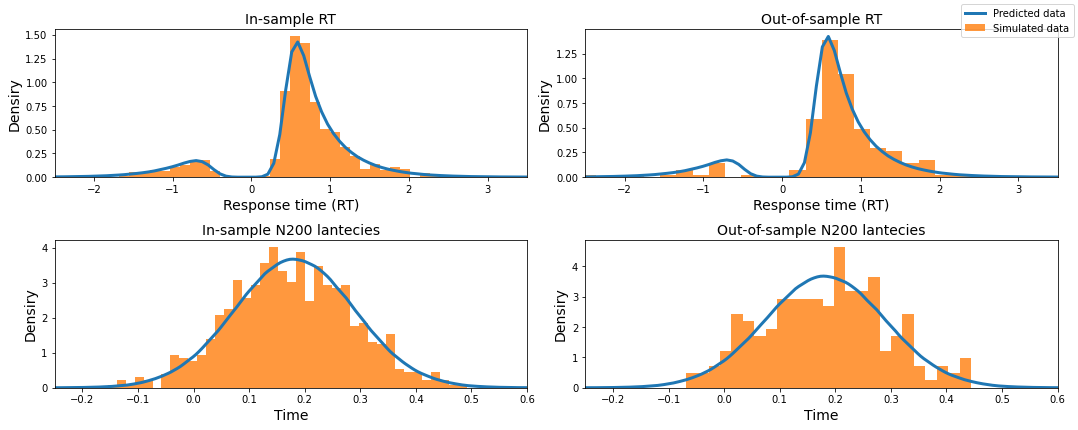

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15,6), tight_layout=True)

sns.kdeplot(x_ppc_in_sample[:,:,0].flatten(),  ax=axes[0, 0], linewidth=3)
axes[0, 0].hist(x_in_sample[0,:,0], density=True, bins=40, alpha=0.8)
axes[0, 0].set_xlim(-2.5,3.5)
axes[0,0].set_ylabel('Densiry', fontsize=14)
axes[0,0].set_xlabel('Response time (RT)', fontsize=14)
axes[0,0].set_title('In-sample RT', fontsize=14)
fig.legend(['Predicted data', 'Simulated data'])

sns.kdeplot(x_ppc_in_sample[:,:,0].flatten(),  ax=axes[0, 1], linewidth=3)
axes[0, 1].hist(x_out_sample[0,:,0], density=True, bins=25, alpha=0.8)
axes[0, 1].set_xlim(-2.5,3.5)
axes[0,1].set_ylabel('Densiry', fontsize=14)
axes[0,1].set_xlabel('Response time (RT)', fontsize=14)
axes[0,1].set_title('Out-of-sample RT', fontsize=14)


sns.kdeplot(x_ppc_in_sample[:,:,1].flatten(),  ax=axes[1, 0], linewidth=3)
axes[1, 0].hist(x_in_sample[0,:,1], density=True, bins=40, alpha=0.8)
axes[1, 0].set_xlim(-.250,.600)
axes[1,0].set_ylabel('Densiry', fontsize=14)
axes[1,0].set_xlabel('Time', fontsize=14)
axes[1,0].set_title('In-sample N200 lantecies', fontsize=14)

sns.kdeplot(x_ppc_in_sample[:,:,1].flatten(),  ax=axes[1, 1], linewidth=3)
axes[1, 1].hist(x_out_sample[0,:,1], density=True, bins=25, alpha=0.8)
axes[1, 1].set_xlim(-.250,.600)
axes[1,1].set_ylabel('Densiry', fontsize=14)
axes[1,1].set_xlabel('Time', fontsize=14)
axes[1,1].set_title('Out-of-sample N200 lantecies', fontsize=14)
plt.savefig('Figure7/N200_single_trial_in_out_sample.png')